In [3]:
# Cell 1: Read the dataset and inspect basic info

import pandas as pd

csv_path = "UpdatedResumeDataSet.csv"  # change if needed

# Try multiple encodings just in case
try:
    df = pd.read_csv(csv_path)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding="latin1")

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

# Try to guess likely text/label columns
possible_text_cols = [c for c in df.columns if any(k in c.lower() for k in ["resume", "text", "summary", "content"])]
possible_label_cols = [c for c in df.columns if any(k in c.lower() for k in ["category", "label", "job", "target"])]

print("\nPossible text columns:", possible_text_cols)
print("Possible label columns:", possible_label_cols)

df.head(3)


Shape: (962, 2)

Columns: ['Category', 'Resume']

Possible text columns: ['Resume']
Possible label columns: ['Category']


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."


In [4]:
# Cell 2: Basic text cleaning

import re

def clean_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)        # keep only alphabets and spaces
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces
    return text

# Apply cleaning to the Resume column
df['cleaned_resume'] = df['Resume'].apply(clean_text)

# Show some samples
df[['Resume', 'cleaned_resume']].head(3)


,Resume,cleaned_resume
0,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Education Details \r\nMay 2013 to May 2017 B.E...,education details may to may b e uit rgpv data...
2,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...


In [5]:
# Cell 3.1: Tokenization
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Test on first resume
df['tokens'] = df['cleaned_resume'].apply(tokenize_text)
df[['cleaned_resume', 'tokens']].head(3)


,cleaned_resume,tokens
0,skills programming languages python pandas num...,"[skills, programming, languages, python, panda..."
1,education details may to may b e uit rgpv data...,"[education, details, may, to, may, b, e, uit, ..."
2,areas of interest deep learning control system...,"[areas, of, interest, deep, learning, control,..."


In [6]:
# Cell 3.2: Stopword Removal
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in nlp.Defaults.stop_words]

df['tokens_no_stop'] = df['tokens'].apply(remove_stopwords)
df[['tokens', 'tokens_no_stop']].head(3)


,tokens,tokens_no_stop
0,"[skills, programming, languages, python, panda...","[skills, programming, languages, python, panda..."
1,"[education, details, may, to, may, b, e, uit, ...","[education, details, b, e, uit, rgpv, data, sc..."
2,"[areas, of, interest, deep, learning, control,...","[areas, interest, deep, learning, control, sys..."


In [7]:
# Cell 3.3: Lemmatization
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc if token.is_alpha]

df['final_tokens'] = df['tokens_no_stop'].apply(lemmatize_tokens)
df[['tokens_no_stop', 'final_tokens']].head(3)


,tokens_no_stop,final_tokens
0,"[skills, programming, languages, python, panda...","[skills, program, language, python, panda, num..."
1,"[education, details, b, e, uit, rgpv, data, sc...","[education, detail, b, e, uit, rgpv, data, sci..."
2,"[areas, interest, deep, learning, control, sys...","[area, interest, deep, learning, control, syst..."


In [8]:
# Cell 4: TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens into single string
df['final_text'] = df['final_tokens'].apply(lambda x: " ".join(x))

# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit features to 5000 for performance
X = tfidf.fit_transform(df['final_text'])

# Target labels
y = df['Category']

print("TF-IDF shape:", X.shape)


TF-IDF shape: (962, 5000)


In [9]:
# Cell 5: Train/Test Split & Model Training

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

print("Model trained successfully!")


Model trained successfully!


In [10]:
# Cell 6: Evaluate the model

from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.99


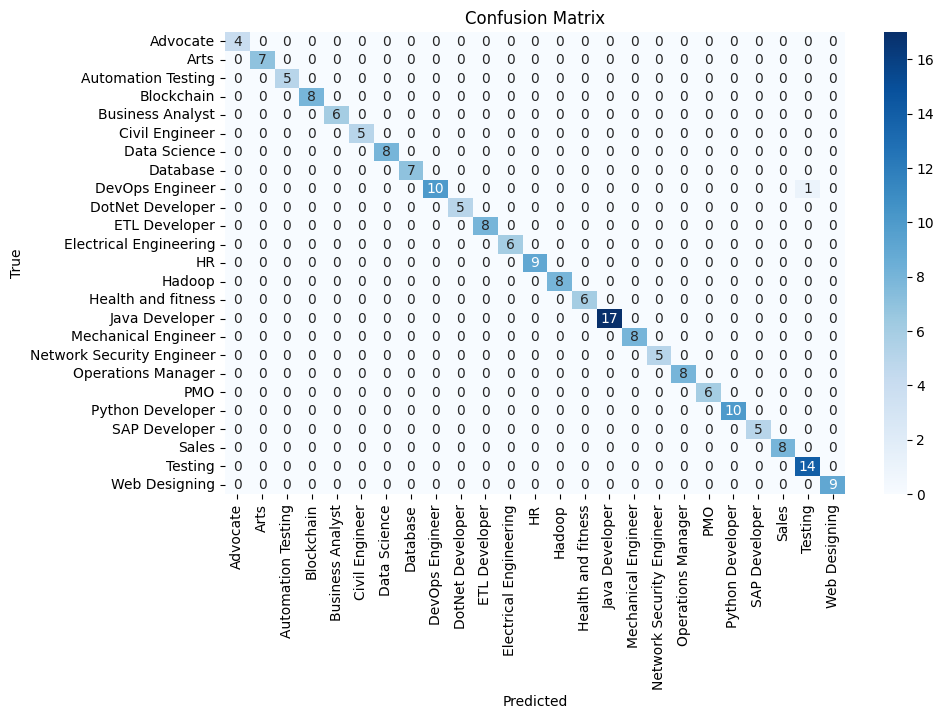

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   Hadoop       1.00      1.00      1.00     

In [11]:
# Cell 7: Confusion Matrix & Classification Report

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))



In [12]:
# Cell: Predict on a new unseen resume

import numpy as np

def preprocess_single_resume(text):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    tokens_no_stop = remove_stopwords(tokens)
    lemmas = lemmatize_tokens(tokens_no_stop)
    return " ".join(lemmas)

def predict_category(resume_text, top_k=3):
    final_text = preprocess_single_resume(resume_text)
    X_new = tfidf.transform([final_text])
    pred = model.predict(X_new)[0]
    proba = model.predict_proba(X_new)[0]
    classes = model.classes_
    top_idx = np.argsort(proba)[::-1][:top_k]
    top_scores = [(classes[i], float(proba[i])) for i in top_idx]
    return pred, top_scores

# ---- try it ----
new_resume = """
Experienced machine learning engineer with strong Python, Pandas, NumPy,
scikit-learn, model deployment (Flask/FastAPI), and NLP experience. Built
end-to-end pipelines, feature engineering, and hyperparameter tuning.
"""

pred_label, top3 = predict_category(new_resume, top_k=3)
print("Predicted category:", pred_label)
print("Top-3 probabilities:")
for lbl, p in top3:
    print(f"  {lbl}: {p:.4f}")


Predicted category: Data Science
Top-3 probabilities:
  Data Science: 0.1988
  Python Developer: 0.0668
  Mechanical Engineer: 0.0543


In [13]:
# Cell: Batch test for 3 other roles

roles = {
    "HR": """
    Experienced HR professional with expertise in recruitment, onboarding,
    payroll processing, performance appraisal systems, employee engagement,
    HRMS tools, and labor law compliance.
    """,
    "Web Developer": """
    Full-stack web developer skilled in HTML, CSS, JavaScript, React, Node.js,
    REST APIs, MongoDB, SQL, Docker, and CI/CD. Built responsive SPAs and optimized
    web performance.
    """,
    "Mechanical Engineer": """
    Mechanical engineer with experience in CAD (SolidWorks, AutoCAD), FEA, thermodynamics,
    manufacturing processes, maintenance planning, and reliability engineering.
    Worked on design optimization and tolerance analysis.
    """
}

for role_name, resume_txt in roles.items():
    pred, top3 = predict_category(resume_txt, top_k=3)
    print(f"\n=== True role: {role_name} ===")
    print("Predicted:", pred)
    print("Top-3 probabilities:")
    for lbl, p in top3:
        print(f"  {lbl}: {p:.4f}")



=== True role: HR ===
Predicted: HR
Top-3 probabilities:
  HR: 0.2808
  Advocate: 0.0553
  Arts: 0.0451

=== True role: Web Developer ===
Predicted: Web Designing
Top-3 probabilities:
  Web Designing: 0.0789
  Java Developer: 0.0777
  Blockchain: 0.0642

=== True role: Mechanical Engineer ===
Predicted: Mechanical Engineer
Top-3 probabilities:
  Mechanical Engineer: 0.2737
  Testing: 0.0464
  Electrical Engineering: 0.0456
